In [280]:

import jax.numpy as jnp

import sys
sys.path.insert(1,'..')
sys.path.append("../../siegel_analyses/scripts/")
import netrep_helpers as nh
import utils
import loader
import setup
import matplotlib.pyplot as plt
import seaborn as sns
%load_ext autoreload
%autoreload 2
import scipy.stats as sts
import numpy as np

import imp
imp.reload(setup)
imp.reload(loader)
import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [281]:


dataloader = loader.IBLDataLoader(
         setup.params,eids=setup.good_eids
)


local md5 mismatch on dataset: cortexlab/Subjects/KS074/2021-11-22/001/alf/probe00/pykilosort/channels.brainLocationIds_ccf_2017.npy
local md5 mismatch on dataset: cortexlab/Subjects/KS074/2021-11-22/001/alf/probe00/pykilosort/channels.mlapdv.npy
../data/2022_Q2_IBL_et_al_RepeatedSite/cortexlab/Subjects/KS074/2021-11-22/001/alf/probe00/pykilosort/channels.brainLocationIds_ccf_2017.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 49.9kB/s]
../data/2022_Q2_IBL_et_al_RepeatedSite/cortexlab/Subjects/KS074/2021-11-22/001/alf/probe00/pykilosort/channels.mlapdv.npy: 100%|██████████| 4.74k/4.74k [00:00<00:00, 48.4kB/s]
local md5 mismatch on dataset: cortexlab/Subjects/KS074/2021-11-22/001/alf/probe00/pykilosort/channels.brainLocationIds_ccf_2017.npy
local md5 mismatch on dataset: cortexlab/Subjects/KS074/2021-11-22/001/alf/probe00/pykilosort/channels.mlapdv.npy
../data/2022_Q2_IBL_et_al_RepeatedSite/cortexlab/Subjects/KS074/2021-11-22/001/alf/probe00/pykilosort/channels.brainLocationIds_ccf_201

In [283]:
def get_dists(train_fold,test_fold,selection="best"):

    xs,ys,_,_ = train_fold
    _,_,rs,cs = test_fold

    # filter bad neurons/sessions
    min_neurons = 100
    min_trials = 20

    valid = [i for i in range(len(ys)) if ys[i].shape[2] >= min_neurons and ys[i].shape[0] >= min_trials]
    ys = [ys[i] for i in valid]
    ys = [y[:,:,jnp.argsort(y.mean(0).std(0))[:100]] for y in ys]

    cs = [cs[i] for i in valid]
    rs = [rs[i] for i in valid]

    S = len(ys)

    #compute distance matrices
    dist_neural = utils.dsd([
        [ys[i].mean(0),ys[j].mean(0)]
        for i in range(len(ys)) 
        for j in range(len(ys))]
    ).reshape(S,S)

    # n_cond = ys[0].shape[1]
    # N = ys[0].shape[2]

    # epsi = 0.01
    # d = []

    # for i in range(S):
    #     cov_i = np.array([np.cov(ys[i][:,c,:].T) + epsi * np.eye(N) 
    #                         for c in range(n_cond)])
        
    #     for j in range(len(ys)):
    #         cov_j = np.array([np.cov(ys[j][:,c,:].T) + epsi * np.eye(N) 
    #                         for c in range(n_cond)])
        
    #         d.append([[ys[i].mean(0),np.array(cov_i)],
    #                 [ys[j].mean(0),np.array(cov_j)]])
                    
    # dist_neural = utils.ssd(d,alpha=1)
    # dist_neural = dist_neural.reshape(S,S)


    # dist_cc = utils.ssd([
    #     [[cs[i].mean(0)[:,None], cs[i].var(0)[:,None,None]],
    #     [cs[j].mean(0)[:,None], cs[j].var(0)[:,None,None]]]
    #     for i in range(len(ys)) 
    #     for j in range(len(ys))],
    #     alpha=2,
    #     niter=1000
    # ).reshape(S,S)


    # dist_cc= utils.dsd([
    #     [cs[i].mean(0)[:,None],cs[j].mean(0)[:,None]]
    #     for i in range(len(ys)) 
    #     for j in range(len(ys))],
    #     alpha=0
    # ).reshape(S,S)

    dist_cc = np.zeros((S,S))

    for i in range(S):
        for j in range(S):
            dist_cc[i,j] = np.mean(np.abs(cs[i].mean(0)- cs[j].mean(0)))

    return dist_neural,dist_cc,cs



def get_kneigh_decreasing(dist_neural,cs,S=10,W=3):

    avg_cc = np.array([np.mean(c,0) for c in cs])
    all_preds_top = []

    for K in range(W,S+1):
        preds_top = []
        for subj in range(S):
            subj_idx =list(range(S))

            #ignore itself
            subj_idx.remove(subj)
            subj_idx = np.array(subj_idx)

            dists = dist_neural[subj][subj_idx] 
            sorted_idx  = subj_idx[np.argsort(dists)]

            s_dists=np.sort(dists)

            weights_top = np.exp(-s_dists[K-W:K])

            top_k = avg_cc[sorted_idx[K-W:K]] #* weights_top[:,None]/np.sum(weights_top[:,None])
        
            preds_top.append(sts.pearsonr(np.mean(top_k,0),avg_cc[subj])[0])

        all_preds_top.append(preds_top)

    all_preds_top = np.array(all_preds_top)
    return all_preds_top

In [289]:

n_folds = 100
n_shuffles = 500

train_data_folds, test_data_folds = dataloader.new_folds(n_folds)


all_c_corrs = []
all_preds_top = []

all_dist_neural = []
all_dist_cc = []

for fold in tqdm.trange(n_folds):
    train_fold, test_fold = train_data_folds[fold],test_data_folds[fold]

    try: 
        dist_neural,dist_cc,cs = get_dists(train_fold,test_fold,selection="best")
    except np.linalg.LinAlgError:
        print("linalg error")
        continue
    
    all_dist_neural.append(dist_neural)
    all_dist_cc.append(dist_cc)
    
    S = dist_neural.shape[0]
    flat_dist_neural = dist_neural[jnp.triu_indices(S,1)]
    flat_dist_cc = dist_cc[jnp.triu_indices(S,1)]

    r,_ = sts.pearsonr(flat_dist_cc,flat_dist_neural)
    preds_top = get_kneigh_decreasing(dist_neural,cs,S,W=2)
    all_preds_top.append(preds_top)

    # compute shuffled correlation
    corrs_shuffle = []
    flat_dist_cc_s =flat_dist_cc.copy()
    for _ in range(n_shuffles):
        np.random.shuffle(flat_dist_cc_s)
        r_s,_ = sts.pearsonr(flat_dist_cc_s,flat_dist_neural)
        corrs_shuffle.append(r_s)

    # save z-scored correlation
    all_c_corrs.append((r - np.mean(corrs_shuffle))/np.std(corrs_shuffle))



all_dist_neural = np.array(all_dist_neural)
all_dist_cc = np.array(all_dist_cc)

100%|██████████| 100/100 [06:32<00:00,  3.93s/it]


In [291]:
np.percentile(all_c_corrs,2.5)

0.9764018627571739

In [292]:
dist_neural = all_dist_neural[np.argmax(all_c_corrs)]
dist_cc = all_dist_cc[np.argmax(all_c_corrs)]


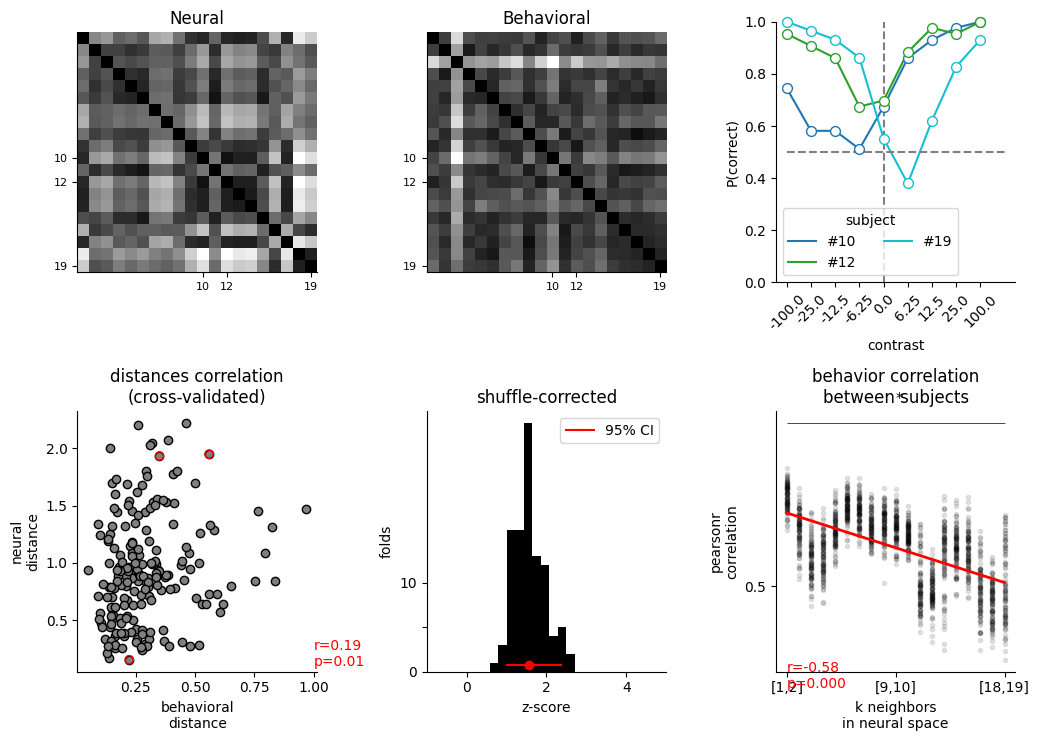

(raylet) [2024-07-18 15:56:07,880 E 45429 1726318] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-07-16_18-49-29_506680_45281 is over 95% full, available space: 49998991360; capacity: 1000240963584. Object creation will fail if spilling is required.
(raylet) [2024-07-18 15:56:17,932 E 45429 1726318] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-07-16_18-49-29_506680_45281 is over 95% full, available space: 48153493504; capacity: 1000240963584. Object creation will fail if spilling is required.
(raylet) [2024-07-18 15:56:28,004 E 45429 1726318] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-07-16_18-49-29_506680_45281 is over 95% full, available space: 46200909824; capacity: 1000240963584. Object creation will fail if spilling is required.
(raylet) [2024-07-18 15:56:38,070 E 45429 1726318] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-07-16_18-49-29_506680_45281 is over 95% full, available space: 44556734464; capacity: 1000240963584. Obj

In [295]:
examples_idx= [10,12,19]
colors = np.array(sns.color_palette(None, S))

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(7*1.5,5*1.5))

### DISTANCE MATRICES
axes = axes.flatten()
axes[0].set_title('Neural')
axes[0].imshow(dist_neural,cmap="gray")
axes[0].set_xticks(examples_idx)
axes[0].set_yticks(examples_idx)


axes[1].set_title('Behavioral')
axes[1].imshow(dist_cc,cmap="gray")
axes[1].set_xticks(examples_idx)
axes[1].set_yticks(examples_idx)

#change ticks fontsize
for ti,tick in enumerate(axes[0].get_xticklabels()):
    tick.set_fontsize(8)
    axes[0].get_yticklabels()[ti].set_fontsize(8)
    axes[1].get_xticklabels()[ti].set_fontsize(8)
    axes[1].get_yticklabels()[ti].set_fontsize(8)


### PSYCHOMETRIC CURVES
contrast = [-100.  ,  -25.  ,  -12.5 ,   -6.25,    0.  ,    6.25,   12.5 ,
         25.  ,  100.  ]

avg_cc = np.array([np.mean(c==1,0) for c in cs])
#avg_cc[:,:4] = 1  - avg_cc[:,:4] 

for si,subj in enumerate(examples_idx):

    axes[2].plot(range(9),avg_cc[subj],label="#%i" % subj,color=colors[subj],clip_on=False) 
    axes[2].scatter(range(9),avg_cc[subj],edgecolors=colors[subj], s=50, facecolors='white', zorder=3,clip_on=False) 

axes[2].set_ylabel("P(correct)")
axes[2].set_xlabel("contrast")
axes[2].legend(title="subject",ncols=2)
axes[2].plot([4,4],[0,1],"--",color="gray")
axes[2].plot([0,9],[0.5,0.5],"--",color="gray")
sns.despine()
axes[2].set_ylim(0,1)
axes[2].set_xticks(range(len(contrast)),contrast,rotation=45)

# take upper triangle
flat_dist_neural = dist_neural[jnp.triu_indices(S,1)]
flat_dist_cc = dist_cc[jnp.triu_indices(S,1)]

r,p = sts.pearsonr(flat_dist_cc,flat_dist_neural)
axes[3].scatter( flat_dist_cc,flat_dist_neural,color="k",facecolors='gray')
axes[3].text(1,0.1,"r={:.2f}\np={:.2f}".format(r,p),color="red")
axes[3].set_xlabel("behavioral\ndistance")
axes[3].set_ylabel("neural\ndistance")
#axes[3].set_xticks([])
#axes[3].set_yticks([])
axes[3].set_title("distances correlation\n(cross-validated)")
axes[3].scatter(dist_cc[examples_idx,:][:,examples_idx][np.triu_indices(len(examples_idx),1)].flatten(),
                dist_neural[examples_idx,:][:,examples_idx][np.triu_indices(len(examples_idx),1)].flatten(),facecolors='none', edgecolors='red',zorder=10)

axes[4].hist(all_c_corrs,color="black")
axes[4].set_xlim(-1,5)
#axes[4].set_ylim(0,10)

axes[4].set_yticks([0,5,10],['0','','10'])
axes[4].set_xlabel("z-score")
axes[4].set_ylabel("folds")
axes[4].set_title("shuffle-corrected")
#assymtric error bar
asymmetric_error = np.array([[np.mean(all_c_corrs) - np.percentile(all_c_corrs,2.5),np.percentile(all_c_corrs,97.5) - np.mean(all_c_corrs)]])

axes[4].errorbar(np.mean(all_c_corrs),0.75,xerr=asymmetric_error.T,color="red",label="95% CI")
axes[4].plot(np.mean(all_c_corrs),0.75,"o",color="red")
axes[4].legend()


_ids = list(range(S-1))*np.shape(all_preds_top)[0]

r=sts.linregress(_ids,np.mean(all_preds_top,2).reshape(-1))

axes[5].plot(np.mean(all_preds_top,2).T,"k.",alpha=0.1)
#axes[5].plot(np.mean(all_preds_top,2).mean(0),"r-",lw=2)
axes[5].set_title("behavior correlation\nbetween subjects")

axes[5].text(0,0.25,"r={:.2f}\np={:.3f}".format(r.rvalue,r.pvalue),color='r')  
axes[5].set_ylabel("pearsonr\ncorrelation")
axes[5].set_yticks([0,0.5,1])
axes[5].set_xticks([0,(S-2)//2,S-2],["[1,2]","[%i,%i]" % ((S-2)//2,(S-2)//2+1),"[%i,%i]" % (S-2,S-1)])
axes[5].set_xlabel("k neighbors\nin neural space")
axes[5].hlines(y=0.9, xmin=0, xmax=18, colors='black',lw=0.5)
#axes[5].set_ylim(.5,1)
axes[5].text(9,.95,"*",color='black')
# plot regression line on top of the data using the slope and intercept
axes[5].plot(range(19)*r.slope+r.intercept,"r-",lw=2)

fig.tight_layout()
sns.despine()

#plt.savefig("../results/main_figure_no_0.5_dds_alpha_0_beh.png",dpi=300)

In [288]:
_ids = list(range(S-1))*np.shape(all_preds_top)[0]

r_values = np.array([sts.linregress(range(S-3),f).rvalue for f in np.mean(all_preds_top,2)])
np.mean(r_values>0)

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 17 and the array at index 1 has size 16

In [ ]:
np.percentile(np.mean(all_preds_top,2)[:,0]-np.mean(all_preds_top,2)[:,-1],2.5)

-0.0339826106567878

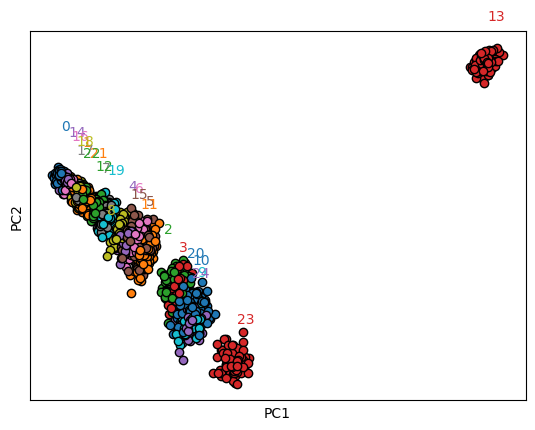

In [ ]:

from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from scipy.spatial import procrustes 

# expand dimensionality to avoid distorcions and then PCA it for plotting 
dist_mds = [MDS(n_components=25,dissimilarity="precomputed",normalized_stress=False).fit_transform(dist) for dist in all_dist_neural]
dist_pca = [PCA(n_components=9,svd_solver='full').fit_transform(dist) for dist in dist_mds]

colors = np.array(sns.color_palette(None, S))
# 3D figure
fig = plt.figure()
ax = fig.add_subplot(111)
for dist_low in dist_pca:
    # alig low dim representations to first one (to avoid PCA rotation invariances)
    _,dist_low,_ = procrustes(dist_pca[0],dist_low )

    for c,i in enumerate(range(0,S)):
       

        ax.plot(dist_low[i,0],dist_low[i,1],"o",color="black",markerfacecolor=colors[c])

labels = ["%i" % i for i in range(S)]
# # Add text as markers
for i, label in enumerate(labels):
    ax.text(dist_low[i,0],dist_low[i,1]+0.05,s=label,color=colors[i])

ax.set_xticks([])   
ax.set_yticks([])

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")

ax.grid(False)

In [ ]:
dist_pca = [PCA(n_components=9,svd_solver='full').fit(dist) for dist in dist_mds]


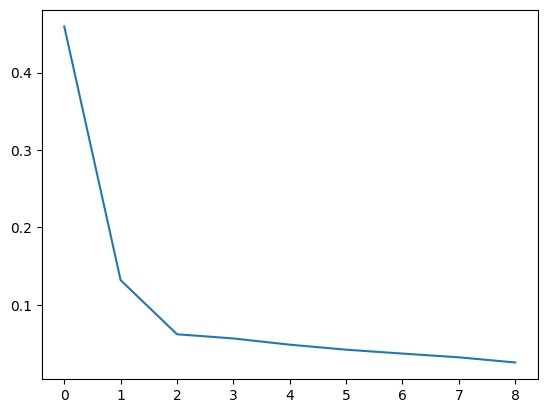

In [ ]:
plt.plot(dist_pca[0].explained_variance_ratio_)

ValueError: The number of FixedLocator locations (4), usually from a call to set_ticks, does not match the number of labels (3).

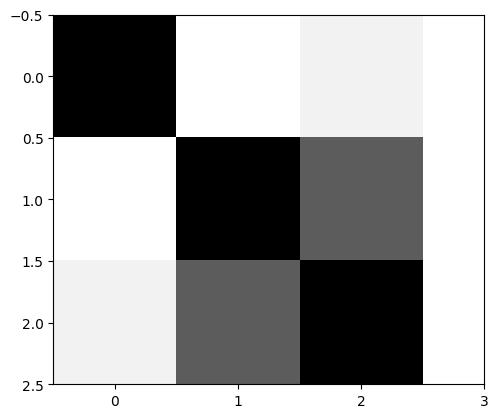

In [ ]:
plt.imshow(dist_neural[examples_idx,:][:,examples_idx],cmap="gray")
plt.xticks(range(4),examples_idx)
plt.yticks(range(4),examples_idx)
plt.colorbar()

plt.figure()
plt.imshow(dist_cc[examples_idx,:][:,examples_idx],cmap="gray")
plt.xticks(range(4),examples_idx)
plt.yticks(range(4),examples_idx)
plt.colorbar()



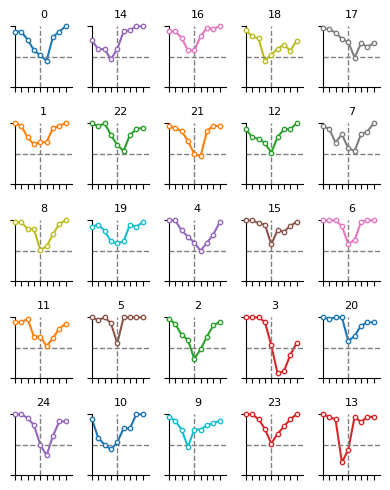

In [ ]:
# contrast = [-100.  ,  -25.  ,  -12.5 ,   -6.25,    0.  ,    6.25,   12.5 ,
#          25.  ,  100.  ]

plt.figure(figsize=(4,5))
#colors = sns.color_palette("viridis",4)
contrast
for si,subj in enumerate(np.argsort(dist_low[:,0])):
    plt.subplot(5,5,si+1)
    plt.title(subj,fontsize=8)
    plt.plot(range(len(contrast)),avg_cc[subj],label="#%i" % subj,color=colors[subj],clip_on=False) 
    plt.scatter(range(len(contrast)),avg_cc[subj],edgecolors=colors[subj], s=10, facecolors='white', zorder=3,clip_on=False) 

    #plt.ylabel("P(right)")
    #plt.xlabel("contrast")
    plt.plot([4,4],[0,1],"--",color="gray",lw=1)
    plt.plot([0,9],[0.5,0.5],"--",color="gray",lw=1)
    sns.despine()
    plt.ylim(0,1)
    plt.xlim(0,9)
    plt.yticks([0,1],[])
    plt.xticks(range(9),[])

plt.tight_layout()